In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import fpl_functions as fpl
pd.options.mode.chained_assignment = None
sns.set_theme()

In [3]:
'''
TODO

- get_team function returns players total scores, not how many points they scored for me
- weighted performance is still a work in progress; needs backtesting
'''

'\nTODO\n\n- get_team function returns players total scores, not how many points they scored for me\n- weighted performance is still a work in progress; needs backtesting\n'

In [4]:
GAMEWEEKS_PLAYED = 4

In [5]:
df = pd.read_excel('data/players_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))
fixtures = pd.read_excel('data/fixtures.xlsx')
my_team = pd.read_excel('data/my_team_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))

In [6]:
my_team

,Players,multiplier,is_captain,is_vice_captain
0,Henderson,1,False,False
1,Pedro Porro,1,False,False
2,Robinson,1,False,False
3,Alexander-Arnold,1,False,False
4,Mykolenko,1,False,False
5,Eze,1,False,False
6,Diogo J.,1,False,False
7,Souček,1,False,False
8,M.Salah,1,False,True
9,Haaland,2,True,False


In [7]:
df.drop(df[df['status'] == 'u'].index, inplace=True)
df = df.drop(df[df['minutes'] == 0].index)

df['now_cost'] = df['now_cost']/10

#create points per million (cost) column (ppm)
df['ppm'] = round(df['total_points']/df['now_cost'], 2)

#create expected goals and goal involvements vs actual goals and goal involvements columns
df['g_vs_xg'] = df['goals_scored'] - df['expected_goals']
df['gi_vs_xgi'] = df['goals_scored'] + df['assists'] - df['expected_goal_involvements']

df['goal_involvements'] = df['goals_scored'] + df['assists']

df['points_per_minute'] = df['total_points']/df['minutes']

df['gc_vs_xgc'] = df['goals_conceded'] - df['expected_goals_conceded']

df['percent_of_season_played'] = np.round(df['minutes']/(GAMEWEEKS_PLAYED*90) * 100, 2)
#drop players who've played less than half the season up until now
df = df.drop(df[df['percent_of_season_played'] < 50].index)

#expected goal involvements per million; could this be a good way to determine which players are "undervalued"?
df['xgi_pm'] = round(df['expected_goal_involvements']/df['now_cost'], 2)

In [8]:
fixtures_going_forward = fixtures.loc[fixtures['Gameweek'] > GAMEWEEKS_PLAYED]

df['next_match'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED+1)[['opponent', 'h_or_a']].iloc[-1]))
df['next_5_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+5)['FDR']))
#df['past_3_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED)['FDR']))
df['next_5_avg_FDRs'] = df['next_5_FDRs'].apply(lambda x: np.round(np.mean(x), 2))
#df['past_3_avg_FDRs'] = df['past_3_FDRs'].apply(lambda x: np.mean(x))

In [9]:
fpl.get_team(df, list(my_team.loc[my_team['multiplier'] > 0]['Players']))

,web_name,position,team,now_cost,selected_by_percent,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,clean_sheets,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
409,Haaland,Forward,Man City,15.2,69.1,99.72,3.55,0.33,"[Arsenal, Home]",3.0,9.0,0.0,9.0,1.0,5.04,3.96,1.26,54.0
386,M.Salah,Midfielder,Liverpool,12.7,46.3,97.78,3.39,0.24,"[Bournemouth, Home]",3.0,3.0,3.0,6.0,3.0,2.99,3.01,0.77,43.0
370,Alexander-Arnold,Defender,Liverpool,7.0,31.6,86.67,3.0,0.29,"[Bournemouth, Home]",3.0,0.0,0.0,0.0,3.0,2.05,-2.05,0.59,21.0
375,Diogo J.,Midfielder,Liverpool,7.6,16.9,78.61,2.37,0.27,"[Bournemouth, Home]",3.0,1.0,1.0,2.0,3.0,2.02,-0.02,0.64,18.0
576,Pedro Porro,Defender,Spurs,5.5,33.9,100.0,3.27,0.18,"[Brentford, Home]",2.4,1.0,0.0,1.0,1.0,1.00,0.00,0.25,18.0
465,Isak,Forward,Newcastle,8.4,38.7,87.5,2.02,0.19,"[Fulham, Away]",3.4,1.0,1.0,2.0,1.0,1.60,0.40,0.46,17.0
221,Eze,Midfielder,Crystal Palace,6.9,25.7,100.0,2.32,0.31,"[Man Utd, Home]",3.0,1.0,0.0,1.0,0.0,2.13,-1.13,0.54,16.0
293,Robinson,Defender,Fulham,4.7,17.5,100.0,3.19,0.08,"[Newcastle, Home]",3.2,0.0,2.0,2.0,0.0,0.36,1.64,0.09,15.0
612,Souček,Midfielder,West Ham,5.0,3.2,62.5,3.0,0.35,"[Chelsea, Home]",2.8,1.0,1.0,2.0,1.0,1.75,0.25,0.70,15.0
223,Henderson,Goalkeeper,Crystal Palace,4.5,14.0,100.0,1.78,0.00,"[Man Utd, Home]",3.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,8.0


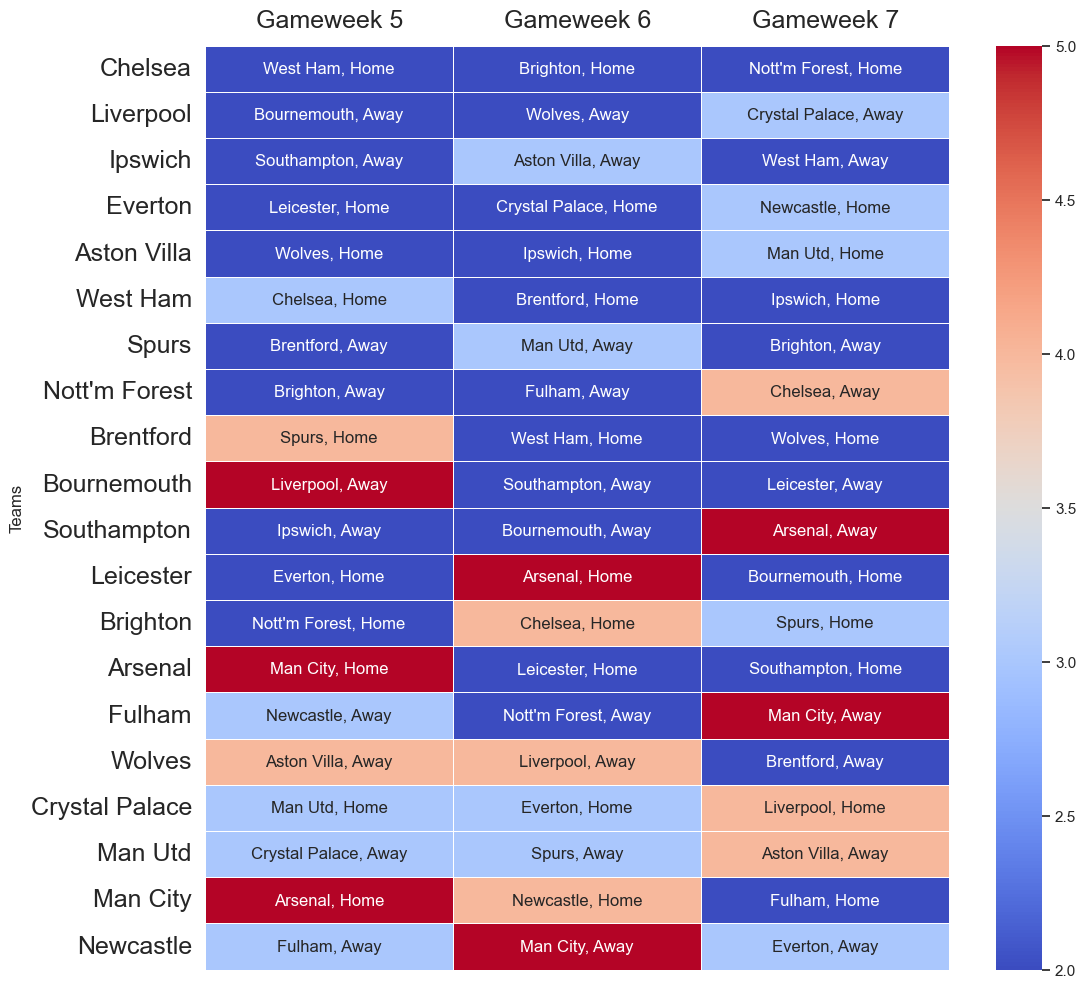

In [10]:
pl_teams = fixtures['team_h'].unique()
fixture_matrix_fdr = pd.DataFrame({'Teams': pl_teams})
fixture_matrix_fdr['next_5_fdr'] = fixture_matrix_fdr['Teams'].apply(lambda x: fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+3)['FDR'].mean())
fixture_matrix_fdr.sort_values(by='next_5_fdr', ascending=True, inplace=True)
fixture_matrix_fdr.drop('next_5_fdr', axis=1, inplace=True)

fixture_matrix_matches = fixture_matrix_fdr.copy()

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        fdr = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['FDR'].values[i-GAMEWEEKS_PLAYED]
        gw_fix.append(fdr)
    fixture_matrix_fdr['Gameweek {}'.format(i+1)] = gw_fix

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        opponent = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['opponent'].values[i-GAMEWEEKS_PLAYED]
        h_or_a = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['h_or_a'].values[-1]
        gw_fix.append('{}, {}'.format(opponent, h_or_a))
    fixture_matrix_matches['Gameweek {}'.format(i+1)] = gw_fix

fig, ax = plt.subplots(figsize=(12,12)) 
ax = sns.heatmap(fixture_matrix_fdr.set_index('Teams'), annot=fixture_matrix_matches.set_index('Teams'), fmt='', linewidth=.5, cmap='coolwarm')
plt.tick_params(axis='both', which='major', labelsize=18, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

In [11]:
first_four_fixtures = pd.DataFrame()
for i in pl_teams:
    temp = fpl.fixtures_by_team(fixtures, i, GAMEWEEKS_PLAYED)
    first_four_fixtures = pd.concat([first_four_fixtures, temp])

first_4_fdrs = pd.DataFrame(first_four_fixtures.groupby('selected_team')['FDR'].sum().astype(int).sort_values(ascending=False)).reset_index()
first_4_fdrs.rename(columns={'selected_team': 'team'}, inplace=True)

#this won't count own goals scored
first_4_gi_xgi = pd.DataFrame(df.groupby('team')[['goals_scored', 'expected_goals', 'g_vs_xg']].sum().sort_values(by='expected_goals', ascending=False)).reset_index()

first_4_gi_xgi

,team,goals_scored,expected_goals,g_vs_xg
0,Man City,11,8.70,2.300000e+00
1,Liverpool,7,7.25,-2.500000e-01
2,Bournemouth,4,6.20,-2.200000e+00
3,Brentford,6,5.81,1.900000e-01
4,Aston Villa,4,5.56,-1.560000e+00
5,Brighton,5,5.45,-4.500000e-01
6,Man Utd,3,5.31,-2.310000e+00
7,Nott'm Forest,4,4.91,-9.100000e-01
8,Chelsea,6,4.90,1.100000e+00
9,Arsenal,5,4.72,2.800000e-01


In [12]:
#join gi vs xgi and fdr tables for first 3 games
first_4_games_table = first_4_gi_xgi.merge(first_4_fdrs, on='team', how='left')
first_4_games_table['FDR'] = first_4_games_table['FDR'] - np.median(first_4_games_table['FDR'].unique())

first_4_games_table

,team,goals_scored,expected_goals,g_vs_xg,FDR
0,Man City,11,8.70,2.300000e+00,-1.5
1,Liverpool,7,7.25,-2.500000e-01,-2.5
2,Bournemouth,4,6.20,-2.200000e+00,-0.5
3,Brentford,6,5.81,1.900000e-01,2.5
4,Aston Villa,4,5.56,-1.560000e+00,-0.5
5,Brighton,5,5.45,-4.500000e-01,1.5
6,Man Utd,3,5.31,-2.310000e+00,-1.5
7,Nott'm Forest,4,4.91,-9.100000e-01,-0.5
8,Chelsea,6,4.90,1.100000e+00,-0.5
9,Arsenal,5,4.72,2.800000e-01,0.5


### Goalkeepers

In [13]:
fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
263,Pickford,Everton,4.9,9.6,9,100.0,1.22,0.01,"[Leicester, Away]",2.2,0,13,13,8.20,4.80,6
103,Flekken,Brentford,4.5,11.0,72,100.0,2.67,0.00,"[Spurs, Away]",2.6,0,22,6,7.56,-1.56,12
347,Hermansen,Leicester,4.5,0.5,43,100.0,1.78,0.00,"[Everton, Home]",2.6,0,14,7,7.11,-0.11,8
597,Areola,West Ham,4.5,8.1,43,87.5,2.44,0.00,"[Chelsea, Home]",2.8,1,10,5,6.63,-1.63,11
223,Henderson,Crystal Palace,4.5,14.0,29,100.0,1.78,0.00,"[Man Utd, Home]",3.0,0,12,7,6.48,0.52,8
477,Pope,Newcastle,5.0,9.0,69,100.0,3.80,0.00,"[Fulham, Away]",3.4,1,16,3,6.25,-3.25,19
329,Muric,Ipswich,4.4,0.5,37,75.0,3.18,0.00,"[Southampton, Away]",2.2,1,10,5,5.95,-0.95,14
521,Ramsdale,Southampton,4.4,1.8,17,50.0,1.14,0.00,"[Ipswich, Home]",3.2,0,11,6,5.45,0.55,5
444,Onana,Man Utd,5.0,5.3,76,100.0,4.20,0.00,"[Crystal Palace, Away]",2.8,2,7,5,5.38,-0.38,21
205,Sánchez,Chelsea,4.5,5.1,71,100.0,4.44,0.00,"[West Ham, Away]",2.8,1,14,5,4.91,0.09,20


In [14]:
fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', True, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
158,Steele,Brighton,4.5,2.4,46,50.0,2.00,0.0,"[Nott'm Forest, Home]",3.0,1,3,1,1.88,-0.88,9
621,Johnstone,Wolves,4.4,0.5,20,50.0,1.14,0.0,"[Aston Villa, Away]",3.4,0,8,3,2.25,0.75,5
162,Verbruggen,Brighton,4.5,2.0,43,50.0,2.00,0.0,"[Nott'm Forest, Home]",3.0,1,7,1,2.43,-1.43,9
369,A.Becker,Liverpool,5.5,13.9,91,100.0,4.18,0.0,"[Bournemouth, Home]",3.0,3,9,1,2.61,-1.61,23
544,McCarthy,Southampton,4.5,0.2,21,50.0,1.33,0.0,"[Ipswich, Home]",3.2,0,7,2,2.70,-0.70,6
643,José Sá,Wolves,4.5,1.9,-1,50.0,0.22,0.0,"[Aston Villa, Away]",3.4,0,6,8,2.80,5.20,1
21,Neto,Arsenal,4.4,1.6,30,50.0,1.59,0.0,"[Man City, Away]",3.0,0,11,2,2.91,-0.91,7
405,Ederson M.,Man City,5.5,8.1,71,100.0,3.45,0.0,"[Arsenal, Home]",3.0,1,10,3,2.99,0.01,19
510,Sels,Nott'm Forest,4.5,2.0,68,100.0,4.44,0.0,"[Brighton, Away]",2.4,2,10,2,3.04,-1.04,20
286,Leno,Fulham,5.0,2.8,52,100.0,2.20,0.0,"[Newcastle, Home]",3.2,0,12,4,4.25,-0.25,11


In [15]:
num_of_goalies = df.loc[df['position'] == 'Goalkeeper'].shape[0]
goalies = fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', False, num_of_goalies)
goalies.groupby('team')[['clean_sheets', 'saves', 'goals_conceded', 'expected_goals_conceded', 'gc_vs_xgc']].sum().sort_values(by='expected_goals_conceded', ascending=False).reset_index()

,team,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc
0,Everton,0,13,13,8.20,4.80
1,Southampton,0,18,8,8.15,-0.15
2,Brentford,0,22,6,7.56,-1.56
3,Arsenal,3,25,3,7.23,-4.23
4,Leicester,0,14,7,7.11,-0.11
5,West Ham,1,10,5,6.63,-1.63
6,Crystal Palace,0,12,7,6.48,0.52
7,Newcastle,1,16,3,6.25,-3.25
8,Ipswich,1,10,5,5.95,-0.95
9,Man Utd,2,7,5,5.38,-0.38


### Defenders

In [16]:
fpl.top_players(df, 'Defender', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,...,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
370,Alexander-Arnold,Liverpool,7.0,31.6,78,86.67,3.00,0.29,"[Bournemouth, Home]",3.0,...,0,0,2.05,-2.05,0.59,3,1,2.04,-1.04,21
517,Milenković,Nott'm Forest,4.5,0.2,48,75.00,3.11,0.22,"[Brighton, Away]",2.4,...,0,0,1.00,-1.00,0.34,2,1,1.82,-0.82,14
549,Sugawara,Southampton,4.5,0.3,53,82.22,2.44,0.23,"[Ipswich, Home]",3.2,...,0,1,1.03,-0.03,0.31,0,8,7.84,0.16,11
39,Digne,Aston Villa,4.6,6.9,71,85.00,3.26,0.20,"[Wolves, Home]",2.4,...,2,2,0.94,1.06,0.28,0,5,3.00,2.00,15
579,Romero,Spurs,5.1,10.1,93,100.00,3.73,0.20,"[Brentford, Home]",2.4,...,0,1,1.04,-0.04,0.26,1,4,4.32,-0.32,19
231,Mitchell,Crystal Palace,4.9,1.8,48,99.44,1.63,0.21,"[Man Utd, Home]",3.0,...,1,1,1.01,-0.01,0.25,0,7,6.48,0.52,8
576,Pedro Porro,Spurs,5.5,33.9,73,100.00,3.27,0.18,"[Brentford, Home]",2.4,...,0,1,1.00,0.00,0.25,1,4,4.26,-0.26,18
408,Gvardiol,Man City,6.0,26.3,65,86.67,2.00,0.13,"[Arsenal, Home]",3.0,...,0,0,0.78,-0.78,0.23,1,2,1.98,0.02,12
413,Lewis,Man City,4.7,11.1,56,87.50,3.19,0.17,"[Arsenal, Home]",3.0,...,1,1,0.80,0.20,0.23,1,3,2.95,0.05,15
393,Robertson,Liverpool,6.0,7.8,84,90.00,3.17,0.13,"[Bournemouth, Home]",3.0,...,0,0,0.78,-0.78,0.21,3,1,2.36,-1.36,19


Look at 4m defenders, which are getting consistent minutes.

In [23]:
fpl.top_players_by_cost(df, 'Defender', 4, 'percent_of_season_played', 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,...,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
257,Keane,Everton,4.0,5.6,8,100.00,2.00,0.07,"[Leicester, Away]",2.2,...,0,1,0.28,0.72,0.06,0,13,8.20,4.80,8
313,Greaves,Ipswich,4.0,2.0,44,100.00,2.25,0.03,"[Southampton, Away]",2.2,...,0,0,0.12,-0.12,0.03,1,7,8.60,-1.60,9
647,Mosquera,Wolves,4.0,1.1,12,100.00,0.50,0.09,"[Aston Villa, Away]",3.4,...,0,0,0.35,-0.35,0.08,0,11,5.05,5.95,2
530,Bednarek,Southampton,4.0,3.3,31,97.22,1.25,0.02,"[Ipswich, Home]",3.2,...,0,0,0.06,-0.06,0.02,0,8,8.15,-0.15,5
547,Stephens,Southampton,4.0,0.9,4,96.67,0.50,0.08,"[Ipswich, Home]",3.2,...,0,0,0.33,-0.33,0.09,0,8,7.38,0.62,2
325,Tuanzebe,Ipswich,4.0,2.0,41,94.72,2.25,0.02,"[Southampton, Away]",2.2,...,0,0,0.09,-0.09,0.03,1,7,8.02,-1.02,9
327,Woolfenden,Ipswich,4.0,1.8,16,75.00,0.50,0.01,"[Southampton, Away]",2.2,...,0,0,0.03,-0.03,0.01,0,7,6.94,0.06,2
536,Harwood-Bellis,Southampton,4.0,10.7,9,63.61,1.00,0.02,"[Ipswich, Home]",3.2,...,0,0,0.07,-0.07,0.03,0,4,4.49,-0.49,4
355,Okoli,Leicester,4.0,0.2,13,50.00,0.25,0.02,"[Everton, Home]",2.6,...,0,0,0.07,-0.07,0.03,0,4,4.09,-0.09,1
361,Vestergaard,Leicester,4.0,3.0,7,50.00,0.50,0.00,"[Everton, Home]",2.6,...,0,0,0.01,-0.01,0.00,0,3,3.01,-0.01,2


### Midfielders

In [17]:
fpl.top_players(df, 'Midfielder', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
403,De Bruyne,Man City,9.6,11.0,89,98.89,1.88,0.35,"[Arsenal, Home]",3.0,1,1,2,3.38,-1.38,0.86,18
385,Luis Díaz,Liverpool,7.7,21.8,115,79.44,4.55,0.34,"[Bournemouth, Home]",3.0,3,1,4,2.63,1.37,0.83,35
386,M.Salah,Liverpool,12.7,46.3,141,97.78,3.39,0.24,"[Bournemouth, Home]",3.0,3,3,6,2.99,3.01,0.77,43
612,Souček,West Ham,5.0,3.2,39,62.50,3.00,0.35,"[Chelsea, Home]",2.8,1,1,2,1.75,0.25,0.70,15
427,B.Fernandes,Man Utd,8.4,11.4,61,96.67,1.43,0.32,"[Crystal Palace, Away]",2.8,0,1,1,2.68,-1.68,0.70,12
90,Tavernier,Bournemouth,5.5,0.3,61,96.11,2.91,0.48,"[Liverpool, Away]",3.6,1,0,1,2.66,-1.66,0.70,16
86,Semenyo,Bournemouth,5.6,6.1,72,100.00,3.57,0.47,"[Liverpool, Away]",3.6,2,1,3,2.64,0.36,0.66,20
575,Maddison,Spurs,7.5,4.2,83,87.78,1.87,0.30,"[Brentford, Home]",2.4,0,2,2,2.28,-0.28,0.65,14
375,Diogo J.,Liverpool,7.6,16.9,41,78.61,2.37,0.27,"[Bournemouth, Home]",3.0,1,1,2,2.02,-0.02,0.64,18
13,Saka,Arsenal,10.0,29.8,109,94.72,3.10,0.24,"[Man City, Away]",3.0,1,4,5,2.42,2.58,0.64,31


In [18]:
fpl.top_players(df, 'Midfielder', 'xgi_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
90,Tavernier,Bournemouth,5.5,0.3,61,96.11,2.91,0.48,"[Liverpool, Away]",3.6,1,0,1,2.66,-1.66,0.70,16
86,Semenyo,Bournemouth,5.6,6.1,72,100.00,3.57,0.47,"[Liverpool, Away]",3.6,2,1,3,2.64,0.36,0.66,20
259,McNeil,Everton,5.4,1.2,113,100.00,4.07,0.47,"[Leicester, Away]",2.2,1,2,3,2.52,0.48,0.63,22
152,Mitoma,Brighton,6.7,10.5,63,97.50,2.84,0.36,"[Nott'm Forest, Home]",3.0,1,1,2,2.44,-0.44,0.63,19
277,Adama,Fulham,5.0,3.5,76,90.28,3.80,0.36,"[Newcastle, Home]",3.2,1,1,2,1.81,0.19,0.50,19
403,De Bruyne,Man City,9.6,11.0,89,98.89,1.88,0.35,"[Arsenal, Home]",3.0,1,1,2,3.38,-1.38,0.86,18
612,Souček,West Ham,5.0,3.2,39,62.50,3.00,0.35,"[Chelsea, Home]",2.8,1,1,2,1.75,0.25,0.70,15
385,Luis Díaz,Liverpool,7.7,21.8,115,79.44,4.55,0.34,"[Bournemouth, Home]",3.0,3,1,4,2.63,1.37,0.83,35
111,Mbeumo,Brentford,7.1,8.8,117,99.72,3.66,0.34,"[Spurs, Away]",2.6,3,0,3,2.38,0.62,0.60,26
427,B.Fernandes,Man Utd,8.4,11.4,61,96.67,1.43,0.32,"[Crystal Palace, Away]",2.8,0,1,1,2.68,-1.68,0.70,12


Look at best midfielders under 7m.

In [19]:
fpl.top_players_by_cost(df, 'Midfielder', 7, 'expected_goal_involvements_per_90', 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
90,Tavernier,Bournemouth,5.5,0.3,61,96.11,2.91,0.48,"[Liverpool, Away]",3.6,1,0,1,2.66,-1.66,0.70,16
612,Souček,West Ham,5.0,3.2,39,62.50,3.00,0.35,"[Chelsea, Home]",2.8,1,1,2,1.75,0.25,0.70,15
86,Semenyo,Bournemouth,5.6,6.1,72,100.00,3.57,0.47,"[Liverpool, Away]",3.6,2,1,3,2.64,0.36,0.66,20
259,McNeil,Everton,5.4,1.2,113,100.00,4.07,0.47,"[Leicester, Away]",2.2,1,2,3,2.52,0.48,0.63,22
152,Mitoma,Brighton,6.7,10.5,63,97.50,2.84,0.36,"[Nott'm Forest, Home]",3.0,1,1,2,2.44,-0.44,0.63,19
56,Ramsey,Aston Villa,5.5,0.4,45,51.11,1.64,0.21,"[Wolves, Home]",2.4,0,1,1,1.17,-0.17,0.57,9
221,Eze,Crystal Palace,6.9,25.7,76,100.00,2.32,0.31,"[Man Utd, Home]",3.0,1,0,1,2.13,-1.13,0.54,16
197,Madueke,Chelsea,6.6,12.2,85,65.28,3.79,0.21,"[West Ham, Away]",2.8,3,0,3,1.39,1.61,0.53,25
275,Smith Rowe,Fulham,5.7,26.5,80,76.11,3.86,0.28,"[Newcastle, Home]",3.2,1,1,2,1.62,0.38,0.53,22
421,Sávio,Man City,6.5,1.3,48,56.94,1.69,0.19,"[Arsenal, Home]",3.0,0,2,2,1.21,0.79,0.53,11


In [22]:
fpl.top_players_by_cost(df, 'Midfielder', 7, 'xgi_pm', 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
90,Tavernier,Bournemouth,5.5,0.3,61,96.11,2.91,0.48,"[Liverpool, Away]",3.6,1,0,1,2.66,-1.66,0.70,16
86,Semenyo,Bournemouth,5.6,6.1,72,100.00,3.57,0.47,"[Liverpool, Away]",3.6,2,1,3,2.64,0.36,0.66,20
259,McNeil,Everton,5.4,1.2,113,100.00,4.07,0.47,"[Leicester, Away]",2.2,1,2,3,2.52,0.48,0.63,22
152,Mitoma,Brighton,6.7,10.5,63,97.50,2.84,0.36,"[Nott'm Forest, Home]",3.0,1,1,2,2.44,-0.44,0.63,19
277,Adama,Fulham,5.0,3.5,76,90.28,3.80,0.36,"[Newcastle, Home]",3.2,1,1,2,1.81,0.19,0.50,19
612,Souček,West Ham,5.0,3.2,39,62.50,3.00,0.35,"[Chelsea, Home]",2.8,1,1,2,1.75,0.25,0.70,15
221,Eze,Crystal Palace,6.9,25.7,76,100.00,2.32,0.31,"[Man Utd, Home]",3.0,1,0,1,2.13,-1.13,0.54,16
151,Minteh,Brighton,5.5,2.5,40,75.56,2.18,0.29,"[Nott'm Forest, Home]",3.0,0,2,2,1.58,0.42,0.52,12
275,Smith Rowe,Fulham,5.7,26.5,80,76.11,3.86,0.28,"[Newcastle, Home]",3.2,1,1,2,1.62,0.38,0.53,22
278,Andreas,Fulham,5.4,2.5,54,96.11,1.48,0.24,"[Newcastle, Home]",3.2,0,0,0,1.31,-1.31,0.34,8


### Forwards

In [20]:
fpl.top_players(df, 'Forward', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
409,Haaland,Man City,15.2,69.1,262,99.72,3.55,0.33,"[Arsenal, Home]",3.0,9,0,9,5.04,3.96,1.26,54
61,Watkins,Aston Villa,8.9,24.2,66,74.44,2.47,0.32,"[Wolves, Home]",2.4,2,1,3,2.84,0.16,0.96,22
97,Evanilson,Bournemouth,5.9,0.3,10,56.11,0.68,0.34,"[Liverpool, Away]",3.6,0,0,0,2.01,-2.01,0.90,4
122,Wissa,Brentford,6.1,7.6,121,80.56,4.59,0.44,"[Spurs, Away]",2.6,3,1,4,2.70,1.30,0.83,28
448,Zirkzee,Man Utd,7.0,3.7,40,69.17,1.71,0.31,"[Crystal Palace, Away]",2.8,1,0,1,2.17,-1.17,0.79,12
200,N.Jackson,Chelsea,7.6,6.7,69,83.33,2.50,0.31,"[West Ham, Away]",2.8,2,1,3,2.37,0.63,0.71,19
630,Cunha,Wolves,6.5,2.3,68,77.78,1.69,0.31,"[Aston Villa, Away]",3.4,1,0,1,1.99,-0.99,0.64,11
228,Mateta,Crystal Palace,7.4,4.3,64,81.39,2.43,0.26,"[Man Utd, Home]",3.0,2,0,2,1.93,0.07,0.60,18
513,Wood,Nott'm Forest,6.1,7.0,70,87.50,3.44,0.28,"[Brighton, Away]",2.4,2,0,2,1.68,0.32,0.48,21
164,Welbeck,Brighton,5.7,17.9,87,93.33,4.39,0.31,"[Nott'm Forest, Home]",3.0,2,1,3,1.79,1.21,0.48,25


In [21]:
fpl.top_players(df, 'Forward', 'xgi_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,xgi_pm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,total_points
122,Wissa,Brentford,6.1,7.6,121,80.56,4.59,0.44,"[Spurs, Away]",2.6,3,1,4,2.70,1.30,0.83,28
97,Evanilson,Bournemouth,5.9,0.3,10,56.11,0.68,0.34,"[Liverpool, Away]",3.6,0,0,0,2.01,-2.01,0.90,4
409,Haaland,Man City,15.2,69.1,262,99.72,3.55,0.33,"[Arsenal, Home]",3.0,9,0,9,5.04,3.96,1.26,54
61,Watkins,Aston Villa,8.9,24.2,66,74.44,2.47,0.32,"[Wolves, Home]",2.4,2,1,3,2.84,0.16,0.96,22
630,Cunha,Wolves,6.5,2.3,68,77.78,1.69,0.31,"[Aston Villa, Away]",3.4,1,0,1,1.99,-0.99,0.64,11
164,Welbeck,Brighton,5.7,17.9,87,93.33,4.39,0.31,"[Nott'm Forest, Home]",3.0,2,1,3,1.79,1.21,0.48,25
200,N.Jackson,Chelsea,7.6,6.7,69,83.33,2.50,0.31,"[West Ham, Away]",2.8,2,1,3,2.37,0.63,0.71,19
448,Zirkzee,Man Utd,7.0,3.7,40,69.17,1.71,0.31,"[Crystal Palace, Away]",2.8,1,0,1,2.17,-1.17,0.79,12
513,Wood,Nott'm Forest,6.1,7.0,70,87.50,3.44,0.28,"[Brighton, Away]",2.4,2,0,2,1.68,0.32,0.48,21
360,Vardy,Leicester,5.6,8.2,71,91.11,3.39,0.27,"[Everton, Home]",2.6,2,0,2,1.51,0.49,0.42,19
